**[ARIMA PYTHON EXAMPLE - 1  (complete)](https://pythonpip.ru/examples/model-arima-v-python)**


**[ARIMA PYTHON EXAMPLE - 2](https://www.8host.com/blog/prognozirovanie-vremennyx-ryadov-s-pomoshhyu-arima-v-python-3/)**

**[ARIMA PYTHON EXAMPLE - 3](https://machinelearningmastery.ru/arima-forecasting-in-python-90d36c2246d3/)**

**[ARIMA PYTHON EXAMPLE - 4](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)**

**[ARIMA PYTHON EXAMPLE - 5](https://habr.com/ru/post/210530/)**

**[ML ARIMA PYTHON EXAMPLE - 6](https://habr.com/ru/company/ods/blog/327242/)**

**[ИЗУЧЕНИЕ МОДЕЛИ - IBM doc](https://www.ibm.com/docs/ru/cloud-paks/cp-data/4.0?topic=node-examining-model)**

**[НОРМАЛЬНОЕ РАСПРЕДЕЛЕНИЕ PYTHON](https://habr.com/ru/company/otus/blog/671322/)**

**[ФИЛЬТР ХЭМПЛЕЯ - СГЛАЖИВАНИЕ ВЫБРОСОВ](https://habr.com/ru/post/703246/)**

**[PMDARIMA - инструкция](https://machinelearningmastery.ru/arima-forecasting-in-python-90d36c2246d3/)**

In [107]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

import time
import sys

import sklearn

import forecast

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_predict

from statsmodels.iolib.table import SimpleTable
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from patsy import dmatrices

In [147]:
def resample_data(data, time_column, interval):
    resempled_data = data[time_column].resample(interval).mean()
    
    try:
        resempled_data.index = pd.DatetimeIndex(data.index).to_period(interval)
    except:
        return resempled_data
    
    resempled_data.dropna()
    
    return resempled_data

In [109]:
def stationarity_test_adf(data):
    
    stationarity_test_result = adfuller(data.dropna())

    print(f'adf-value: %.10f' % stationarity_test_result[0])
    print('p-value: %.10f' % stationarity_test_result[1])
    print(f'critical values {stationarity_test_result[4]}')


    if stationarity_test_result[1] > 0.05:
        print('''
%.10f > 0.05
Нулевая гипотеза не отвергнута
Временной ряд не стационарен''' % stationarity_test_result[1])

    else:
        print('''
%.10f < 0.05
Нулевая гипотеза отвергнута.
Временной ряд стационарен.
Порядок d равен 0''' % stationarity_test_result[1])
    return

In [146]:
def plot_acf_pacf(data, lags_count):
    
    fig = plt.figure(figsize=(12,8))

    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data.dropna(), lags = lags_count, ax = ax1)

    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data.dropna(), lags = lags_count, ax = ax2)
    
    return 

In [199]:
path = '/home/kei/Desktop/data/innostage/innostage_task_5/tsData.json'

In [200]:
ts_data = pd.read_json(path)
original_df = ts_data.rename(columns = {'cnt': 'count'})


In [212]:
mean_df = resample_data(original_df, 'count', '20Min')

<Axes: >

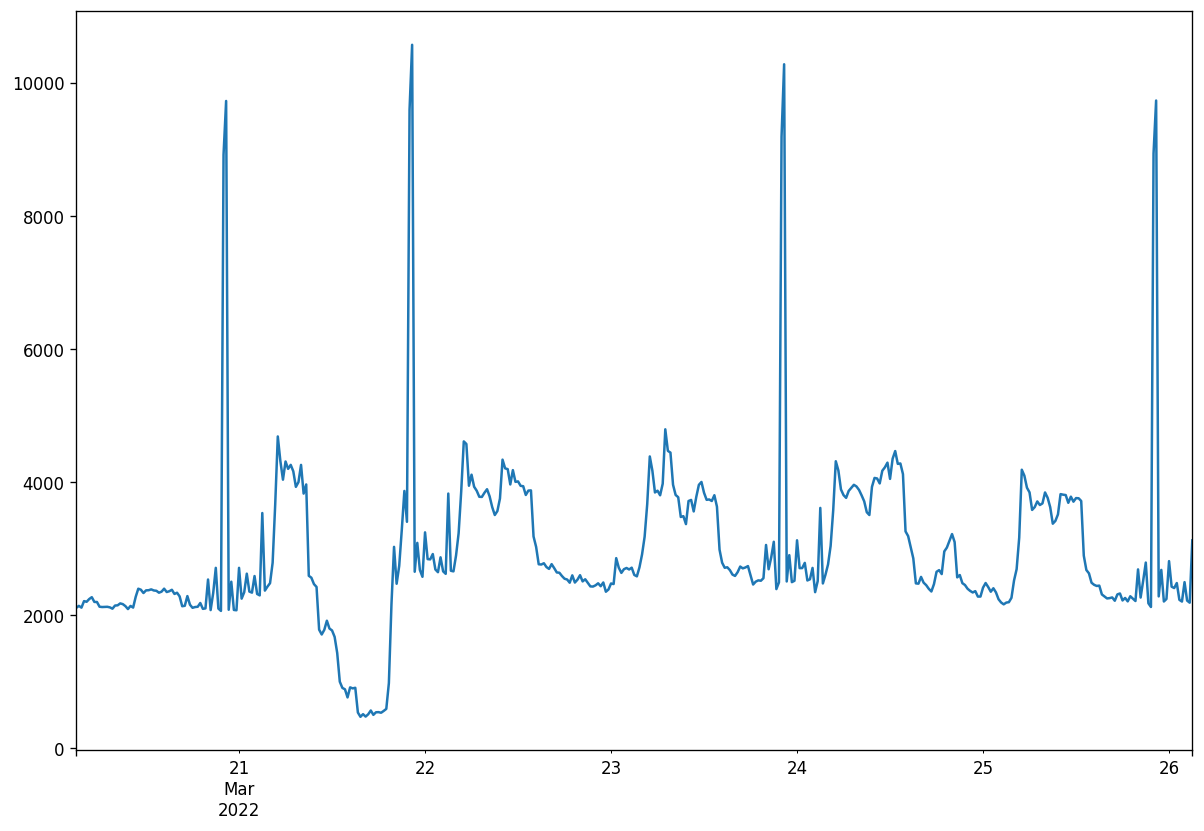

In [213]:
mean_df.plot(figsize = (12, 8))

<Axes: >

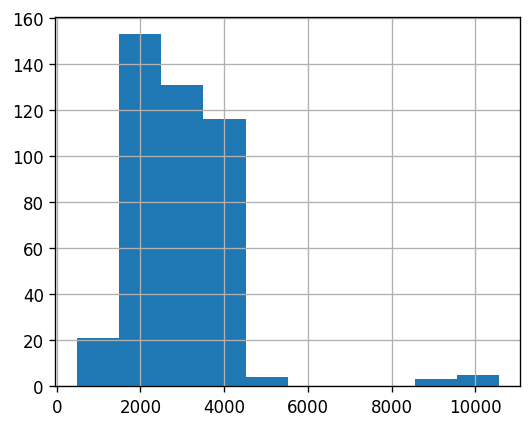

In [214]:
mean_df.hist(figsize = (5, 4))

In [215]:
stationarity_test_adf(mean_df)

adf-value: -5.1094654442
p-value: 0.0000134174
critical values {'1%': -3.445721386098794, '5%': -2.868316661451884, '10%': -2.5703797268320376}

0.0000134174 < 0.05
Нулевая гипотеза отвергнута.
Временной ряд стационарен.
Порядок d равен 0


/home/kei/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


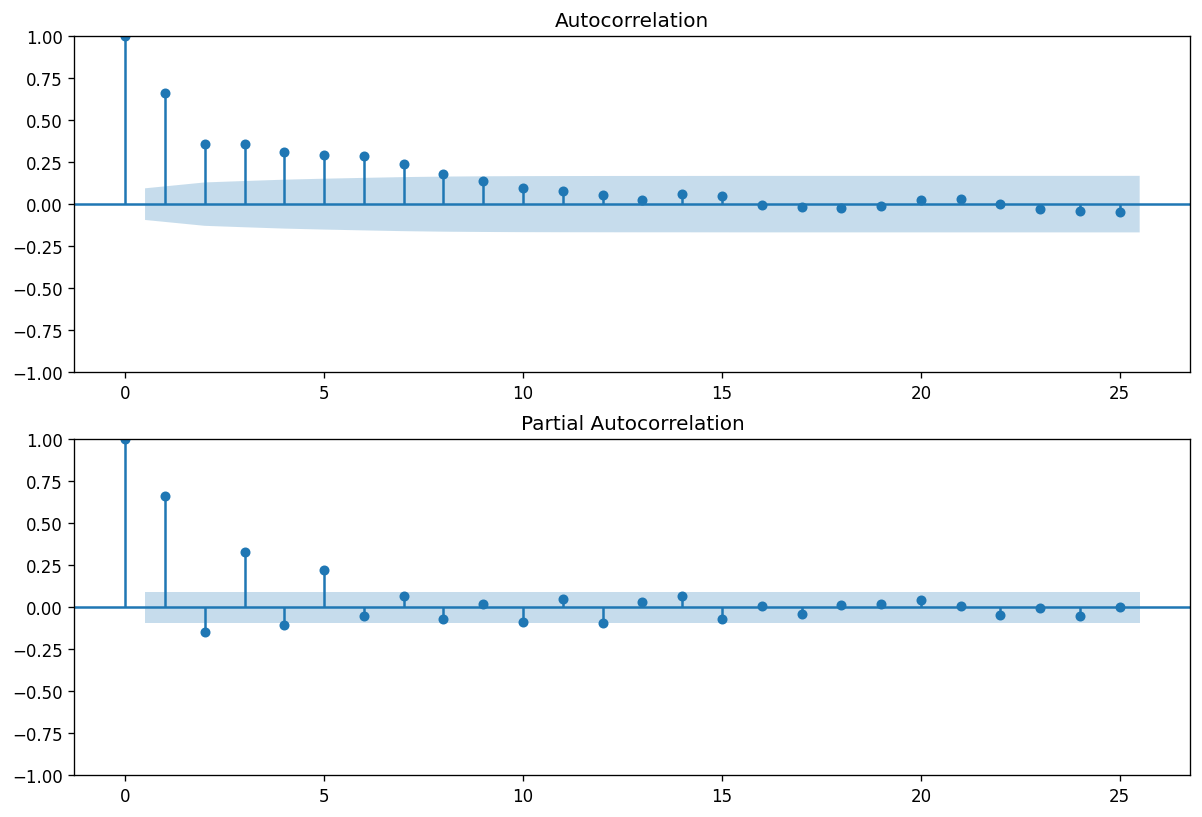

In [216]:
plot_acf_pacf(mean_df, 25)

In [266]:
first_model = ARIMA(mean_df, order = (5, 0, 3)).fit()

In [268]:
print(first_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  433
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -3531.244
Date:                Fri, 03 Mar 2023   AIC                           7082.488
Time:                        21:59:50   BIC                           7123.196
Sample:                    03-20-2022   HQIC                          7098.558
                         - 03-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2947.6185    345.925      8.521      0.000    2269.617    3625.620
ar.L1          1.3277      0.619      2.146      0.032       0.115       2.540
ar.L2         -0.6573      0.558     -1.177      0.2

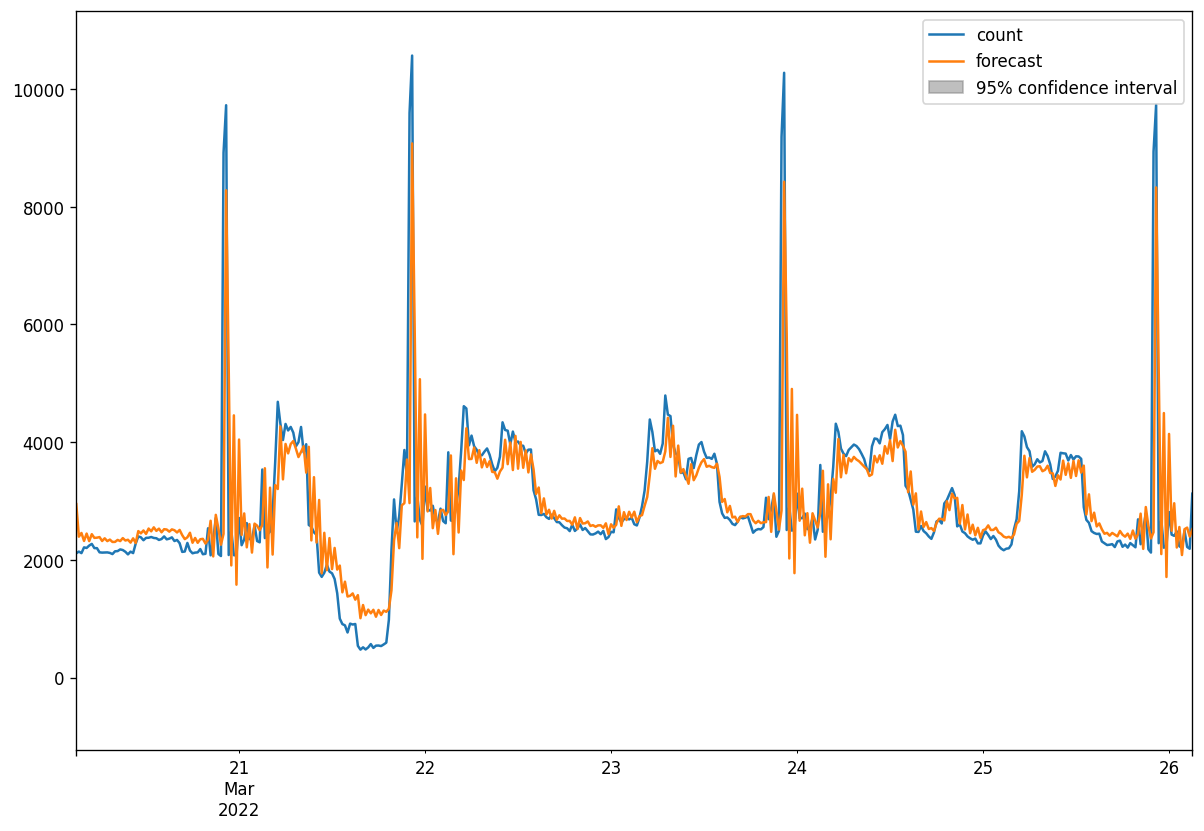

In [269]:
fig, ax = plt.subplots(figsize = (12, 8))

ax = mean_df.plot(ax=ax)

plot_predict(first_model, '2022-03-20', '2022-03-26', ax=ax, dynamic = False)

plt.show()

In [270]:
first_model_predict = first_model.predict('2022-03-26', '2022-03-28', dynamic = False)

<Axes: >

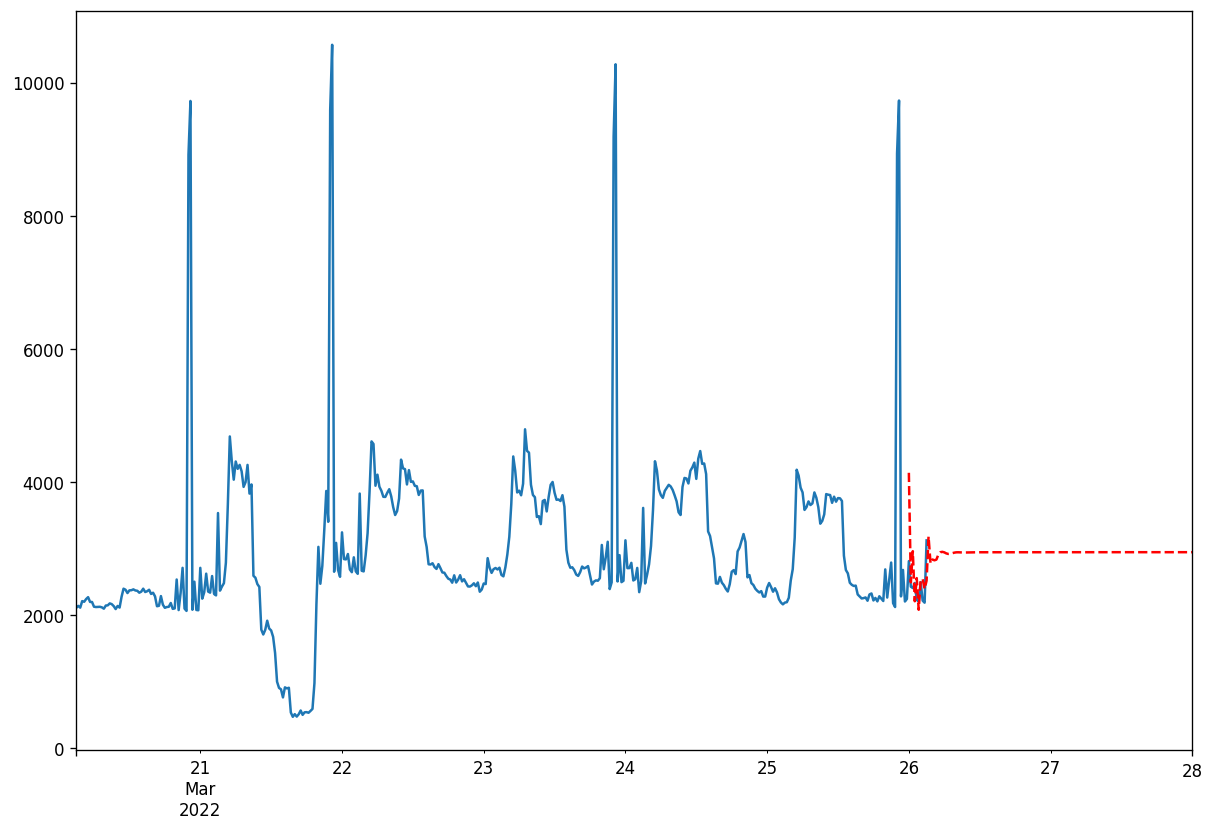

In [271]:
mean_df.plot(figsize = (12, 8))
first_model_predict.plot(figsize = (12, 8), style = 'r--')

### Stage 2

In [272]:
upper_lim = original_df['count'].quantile(.90)
lower_lim = original_df['count'].quantile(.05)
data = original_df[(original_df['count'] < upper_lim) & (original_df['count'] > lower_lim)]

<Axes: >

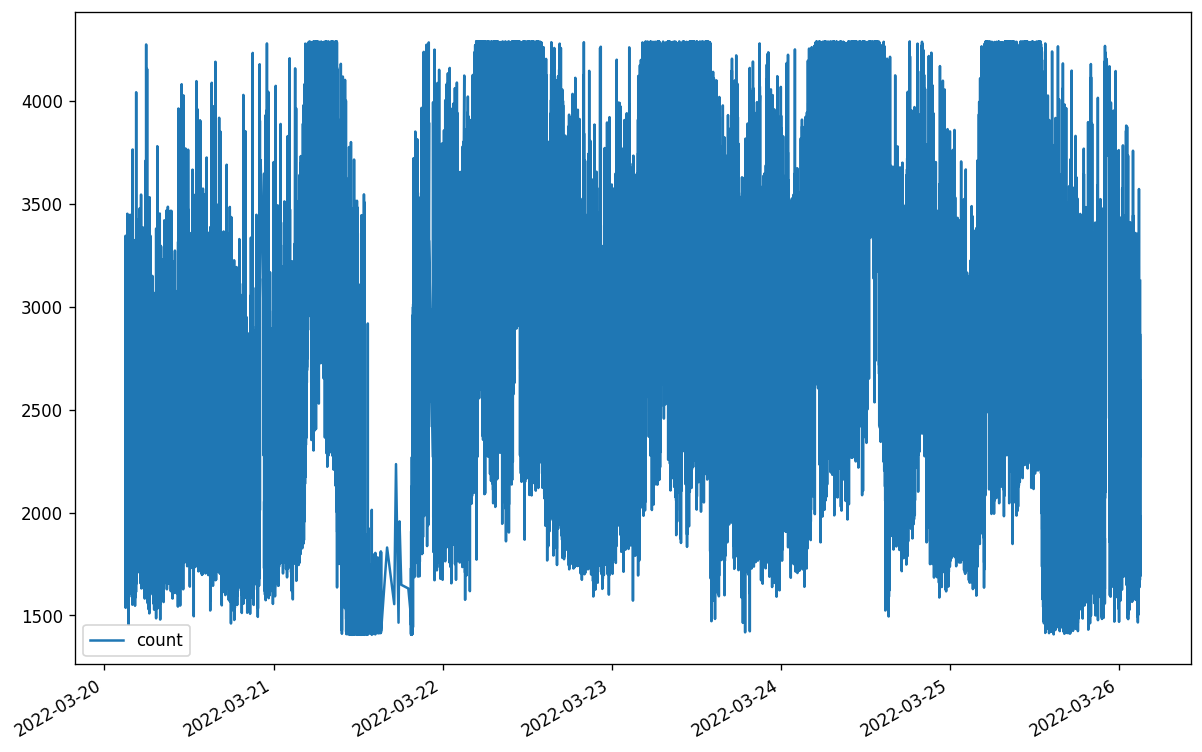

In [273]:
data.plot(figsize = (12, 8))

In [274]:
mean_data_series = resample_data(data, 'count', '1H')

<Axes: >

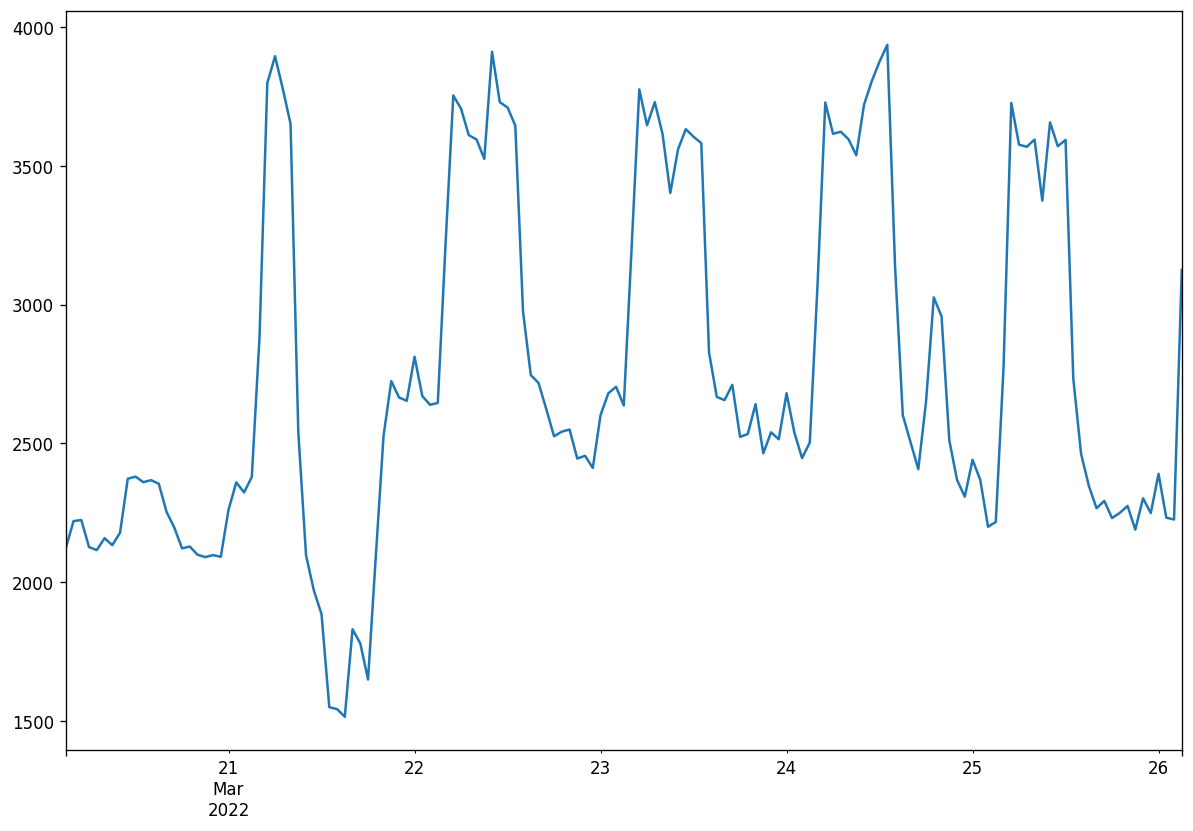

In [275]:
mean_data_series.plot(figsize = (12, 8))

In [276]:
stationarity_test_adf(mean_data_series)

adf-value: -4.0756709115
p-value: 0.0010621981
critical values {'1%': -3.4769274060112707, '5%': -2.8819726324025625, '10%': -2.577665408088415}

0.0010621981 < 0.05
Нулевая гипотеза отвергнута.
Временной ряд стационарен.
Порядок d равен 0


/home/kei/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


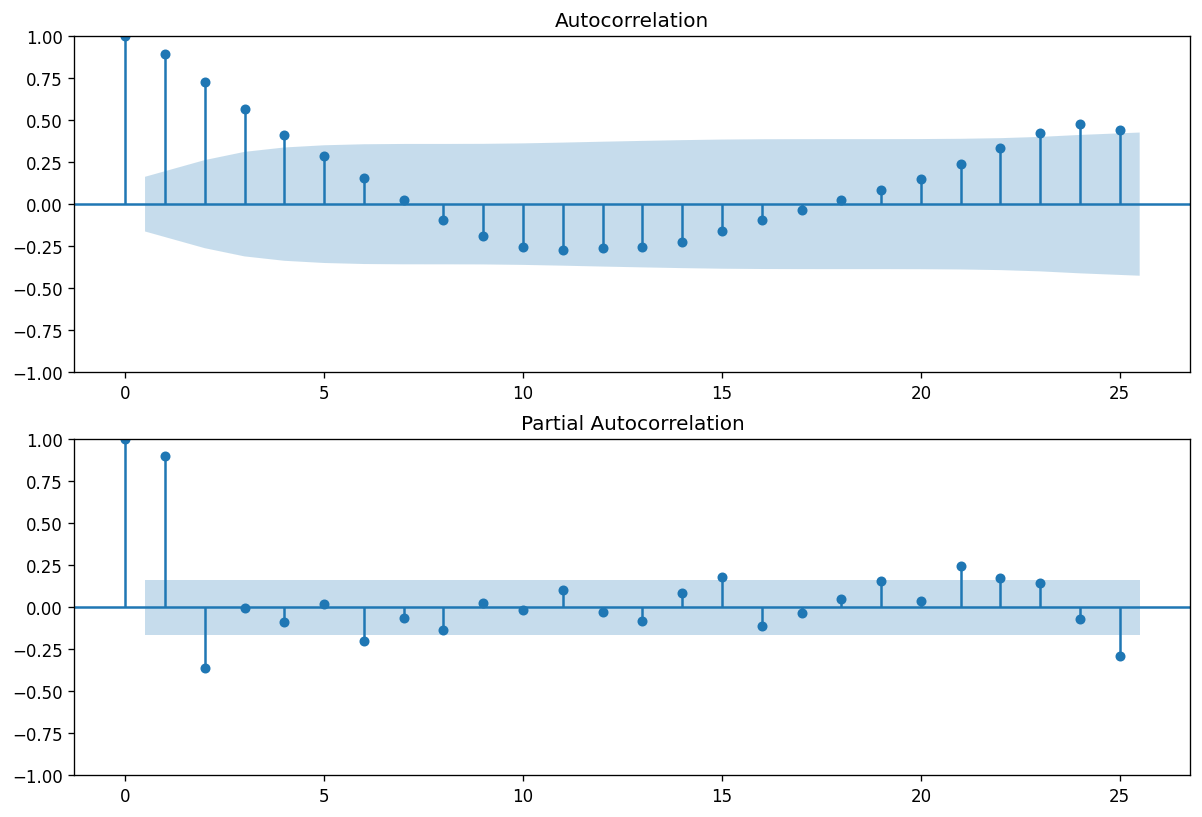

In [277]:
plot_acf_pacf(mean_data_series, 25)

In [278]:
second_model = ARIMA(mean_data_series, order = (24, 0, 23)).fit()

/home/kei/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/kei/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/kei/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [279]:
print(second_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  145
Model:               ARIMA(24, 0, 23)   Log Likelihood                -979.274
Date:                Fri, 03 Mar 2023   AIC                           2056.547
Time:                        22:02:56   BIC                           2202.407
Sample:                    03-20-2022   HQIC                          2115.815
                         - 03-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2755.2631    360.297      7.647      0.000    2049.094    3461.432
ar.L1          0.0571      0.676      0.084      0.933      -1.269       1.383
ar.L2          0.1937      0.524      0.370      0.7

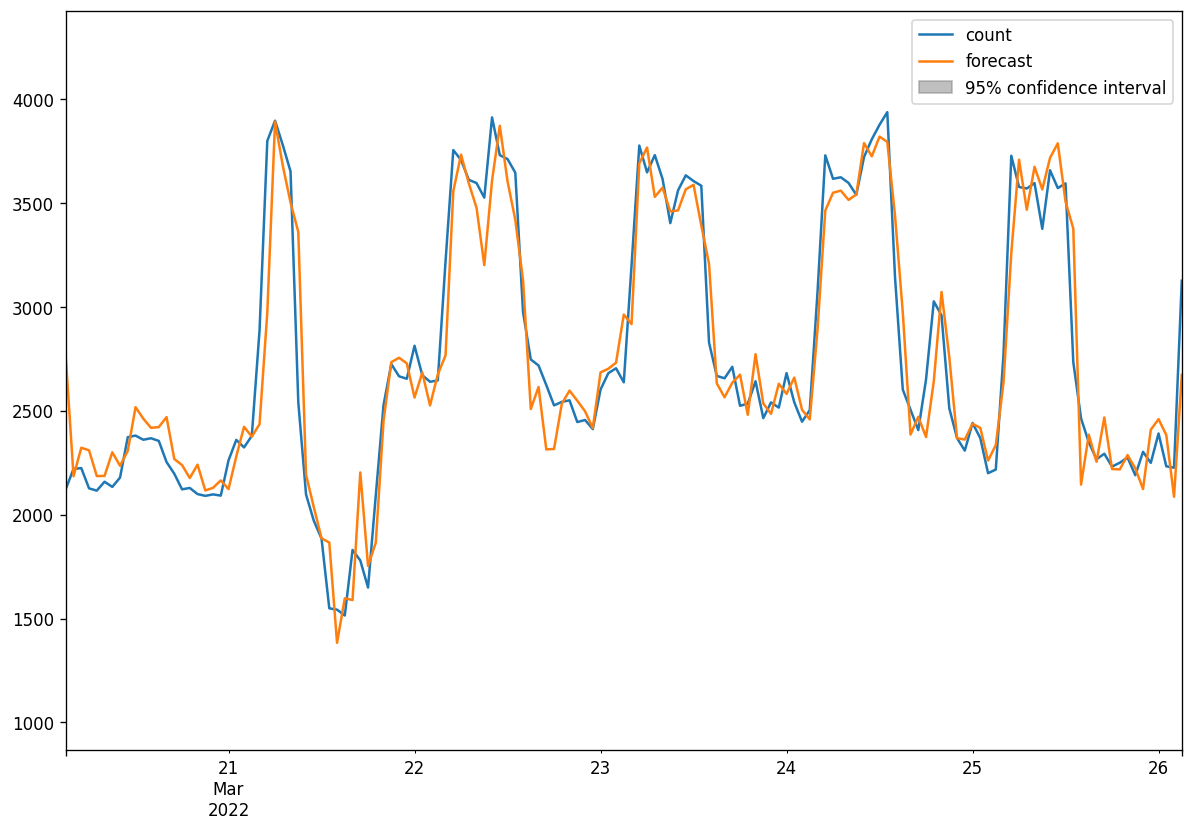

In [281]:
fig, ax = plt.subplots(figsize = (12, 8))

ax = mean_data_series.plot(ax=ax)

plot_predict(second_model, '2022-03-20', '2022-03-26', ax=ax, dynamic = False)

plt.show()

In [317]:
second_model_predict = model.predict('2022-03-26', '2022-03-28', dynamic = False)

<Axes: >

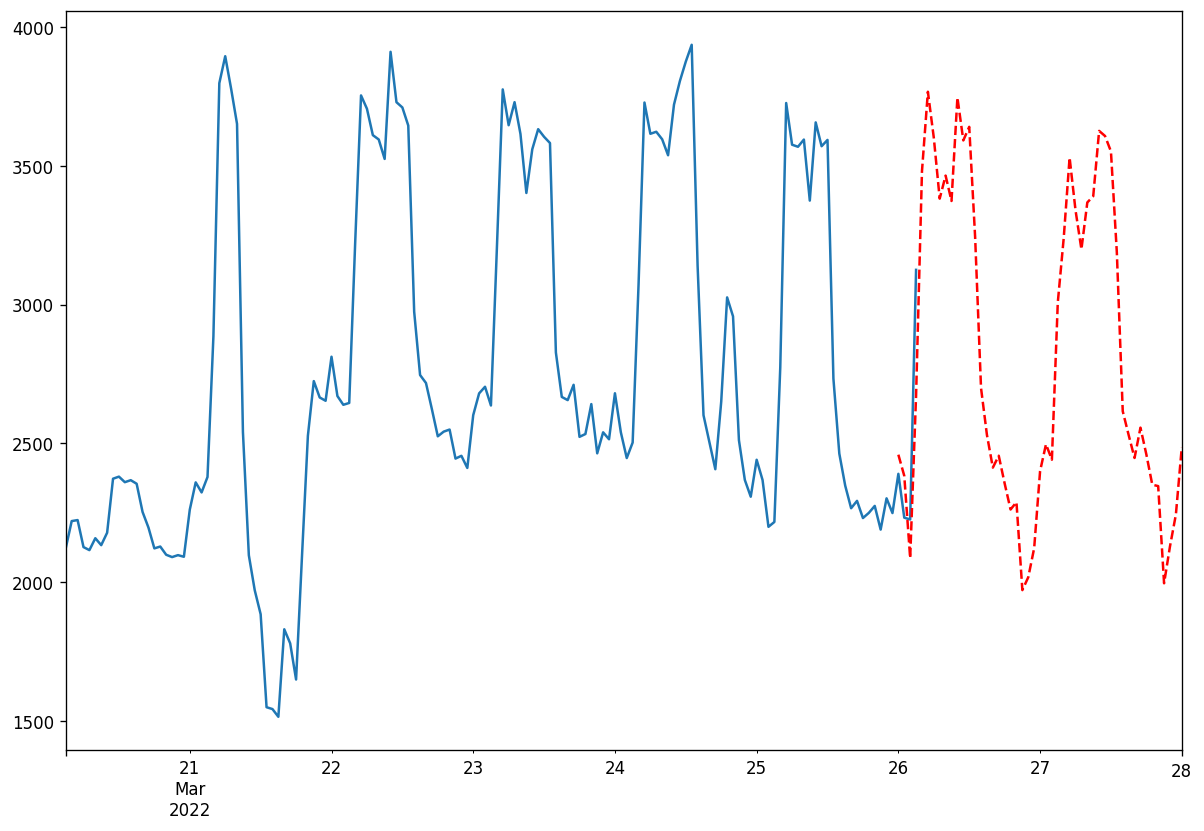

In [318]:
mean_data_series.plot(figsize = (12, 8))
second_model_predict.plot(figsize = (12, 8), style = 'r--')

In [319]:
# Анализ остатков

In [320]:
y_true = mean_data_series[:]
y_pred = second_model_predict[:]

In [321]:
mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true)) # Mean absolute percentage error

mae = np.mean(np.abs(y_pred - y_true)) # Mean absolute error

mpe = np.mean((y_pred - y_true) / y_true) # Mean percentage error

rmse = np.mean((y_pred - y_true) ** 2) ** .5 # RMSE


In [322]:
print(f'Mean absolute percentage error: {mape}\nMean absolute error: {mae}\nMean percentage error: {mpe}\nRMSE: {rmse}')

Mean absolute percentage error: 0.07602706282833582
Mean absolute error: 203.06649538291686
Mean percentage error: -0.027815674901552182
RMSE: 250.93909893070014


In [324]:
mse_model = first_model.mse
mse_second_model = second_model.mse

In [325]:
myresiduals_1 = pd.DataFrame(first_model.resid)
myresiduals_2 = pd.DataFrame(second_model.resid)
plt.rcParams.update({'figure.figsize' :(12,5), 'figure.dpi' : 120})

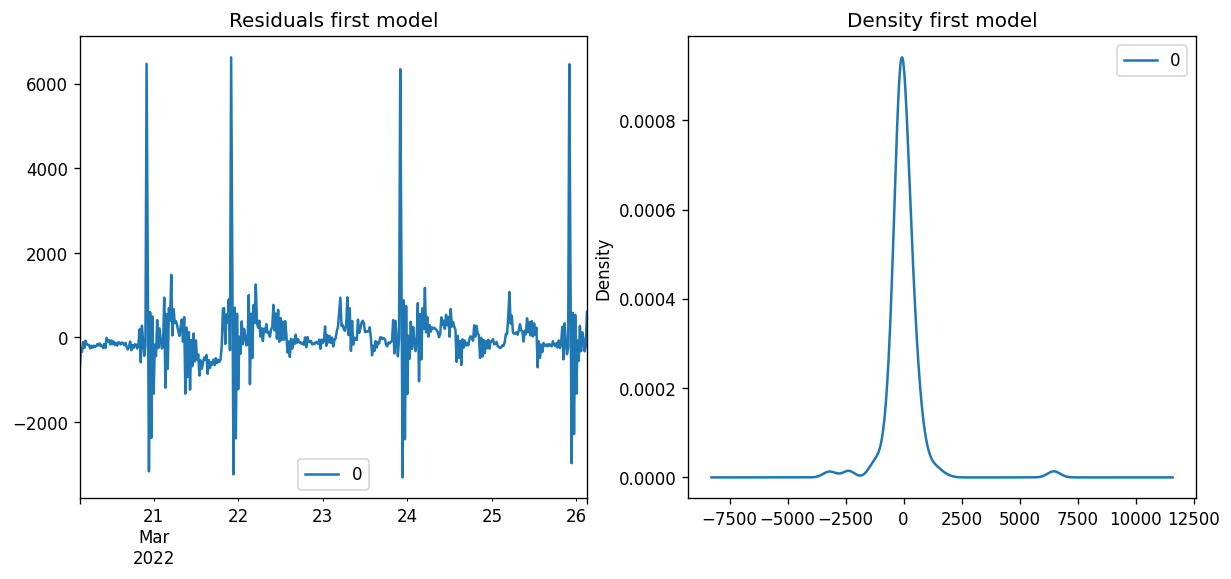

In [326]:
fig, ax = plt.subplots(1,2) 
myresiduals_1.plot(title = "Residuals first model", ax = ax[0]) 
myresiduals_1.plot(kind = 'kde', title = 'Density first model', ax = ax[1]) 
plt.show()

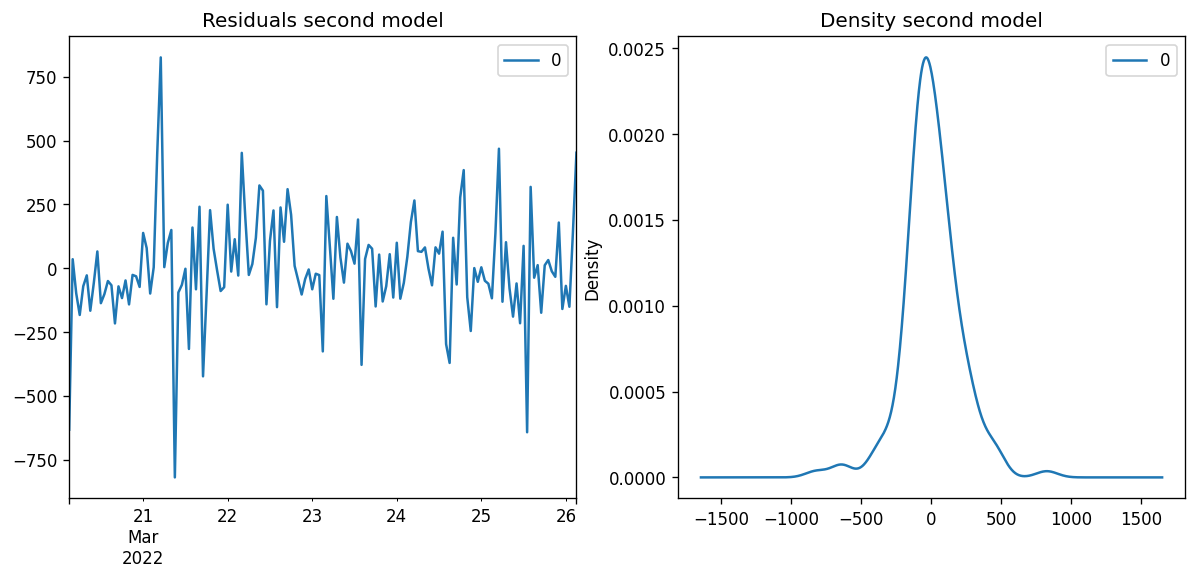

In [327]:
fig, ax = plt.subplots(1,2) 

myresiduals_2.plot(title = "Residuals second model", ax = ax[0]) 
myresiduals_2.plot(kind = 'kde', title = 'Density second model', ax = ax[1]) 
plt.show()